In [19]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from utilities.util import *
from utilities.data_utils import *

import pickle as pkl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import copy
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from matplotlib.ticker import MultipleLocator

In [20]:
folder = '/Users/jendawk/logs/aug9-fingerprints/'
METRIC='AUC'
case=''
fingerprints = ['infomax','morgan','mqn','pubchem','map4']
res_dict={'medians':{},'error_u':{},'error_l':{}}
st_dict = {'data':{}}
data_plot={}
for root, dirs, files in os.walk(folder):
    if 'results_last.csv' in files and any([f in root for f in fingerprints]) and 'seqs' not in root:
        if case not in root:
            continue
        # if 'wang' in root:
        #     print(root)
        fp = [f for f in fingerprints if f in root][0]
        dataset = root.split(folder)[-1].split(f'_{fp}/')[0]
        res = pd.read_csv(os.path.join(root,'results_last.csv'), index_col=0).iloc[:-5,:]
        tmp = res[METRIC].values
        if dataset not in res_dict['medians'].keys():
            for k in res_dict.keys():
                res_dict[k][dataset]={}
            st_dict['data'][dataset]={}
        if fp in res_dict['medians'][dataset]:
            print(f'ERROR: DUPLICATE RESULTS FOR {dataset}, {fp}')
        res_dict['medians'][dataset][fp] = np.median(tmp)
        res_dict['error_u'][dataset][fp] = np.percentile(tmp,95)-np.median(tmp)
        res_dict['error_l'][dataset][fp] = np.median(tmp)-np.percentile(tmp,5)

        st_dict['data'][dataset][fp] = tmp
        data_plot[(fp,dataset)]=tmp

In [21]:
pvals = {}
fdr={}
p=[]
keys=[]
fingerprints = ['infomax','morgan','mqn','pubchem','map4']
for dataset in st_dict['data'].keys():
    pvals[dataset]={}
    fdr[dataset]={}
    p=[]
    keys=[]
    for f1,f2 in itertools.combinations(fingerprints,2):
        if f1=='pubchem' or f2=='pubchem':
            try:
                tmp = st.mannwhitneyu(st_dict['data'][dataset][f1], st_dict['data'][dataset][f2])
                pvals[dataset][f'{f1} vs {f2}'] = tmp.pvalue
                keys.append((dataset,f1,f2))
                p.append(tmp.pvalue)
            except:
                continue

    # if len(p)>0:
    _, corr, _, _ = multipletests(p, alpha=0.05)
    for i,key in enumerate(keys):         
        fdr[keys[i][0]][f'{keys[i][1]} vs {keys[i][2]}'] = corr[i]

/Users/jendawk/miniforge3/envs/py311_arm/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


/var/folders/kg/lq54nq416jqg1h8qrw2_tsp80000gn/T/ipykernel_93644/2363009398.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["He et al.","Dawkins et al.",
/var/folders/kg/lq54nq416jqg1h8qrw2_tsp80000gn/T/ipykernel_93644/2363009398.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


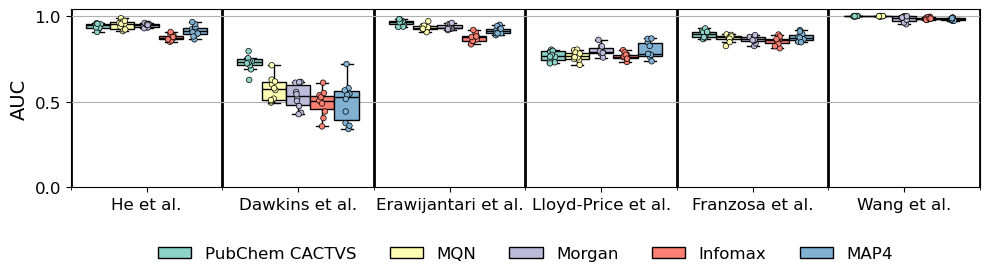

In [22]:
cmap = "Set3"
fnames = ['PubChem CACTVS','MQN','Morgan','Infomax','MAP4']
tb = pd.DataFrame(data_plot)
tb.index = [METRIC]*tb.shape[0]
stacked = tb.T.stack().reset_index().iloc[:,[0,1,3]]
stacked.columns = ['Fingerprint','Dataset',METRIC]
fig, ax = plt.subplots(figsize=(10,3.25))
datasets = ['he','cdi','erawijantari','ibmdb','franzosa','wang']
sns.stripplot(data=stacked, x='Dataset',y=METRIC,hue='Fingerprint', dodge=True, legend=False, ax=ax, edgecolor='k',linewidth=0.5, 
              order=datasets, size=4, alpha=1, palette=cmap,hue_order=['pubchem','mqn','morgan','infomax','map4']) 
f=sns.boxplot(data=stacked, x='Dataset',y=METRIC,hue='Fingerprint',ax=ax, showfliers=False,saturation=1, order=datasets, palette=cmap,
             hue_order=['pubchem','mqn','morgan','infomax','map4'], linecolor='k')
handles, _ = f.get_legend_handles_labels()
f.tick_params(labelsize=12)
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_yticks([0.0,0.5,1])
ax.xaxis.grid(True, which='minor', color='black', lw=2)
# ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.grid(True) # Hide the horizontal gridlines
# ax.xaxis.grid(True, which='major', color='gray',lw=0.5)
ax.set_ylim(0,1.04)
ax.set_ylabel(METRIC, fontsize=14)
ax.set_xlabel('')
ax.set_xticklabels(["He et al.","Dawkins et al.",
            "Erawijantari et al.","Lloyd-Price et al.",
            "Franzosa et al.","Wang et al."], fontsize=12)
f.legend(loc='lower center', bbox_to_anchor=(0.5,-0.5), ncol=len(ax.lines), fontsize=12, 
         frameon=False, handles=handles, labels=fnames)
# sns.catplot(data=stacked, x='Dataset',y=METRIC,hue='Method', dodge=True, legend=False, ax=ax, edgecolor='k',linewidth=1) 
# sns.catplot(kind="box",data=stacked, x='Dataset',y=METRIC,hue='Method',ax=ax, showfliers=False,saturation=0.75)
fig.tight_layout()
fig.savefig(f'/Users/jendawk/Dropbox (MIT)/MDITRE-Metabolites Paper/FINAL_FIGURES/S1-FingerprintResults/Links/{METRIC}.jpeg',
   transparent=True, format='jpeg', dpi=600)

fig.show()